### Libs imports

In [1]:
# Execute extenttion to reload files in project dir
%load_ext autoreload
%autoreload 2

In [2]:
# Add link to project root
import sys, os
sys.path.append(os.path.abspath('..'))

In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from time import sleep

from source.data.get.binance_prices import get_binance_symbols, get_candles_spot_binance
import config

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Get data

In [189]:
# Donwload prices form binance

def compose_binance_candles_df(symbols:list, start_time:str, end_time:str = None):
    results_df = pd.DataFrame(columns=["Time", "Open", "High", "Low", "Close", "Volume", "Symbol"]).set_index("Time")
    
    for symbol in tqdm(symbols):
        try:
            df = get_candles_spot_binance(symbol, "1d", start_time=start_time)
            if not df.empty:
                df.loc[:, "Symbol"] = symbol
                results_df = pd.concat([results_df if not results_df.empty else None, df])
        except ConnectionError:
            sleep(10)
            df = get_candles_spot_binance(symbol, "1d", start_time=start_time)
            if not df.empty:
                df.loc[:, "Symbol"] = symbol
                results_df = pd.concat([results_df if not results_df.empty else None, df])
    return results_df

def create_lag_features(data, column_names, lag=1):
    """
    Create lag features for a specific column in a DataFrame.

    Args:
    - data: Pandas DataFrame containing the dataset
    - column_name: Name of the column for which lag features will be created
    - lag: Number of time steps to shift the column (default is 1)

    Returns:
    - DataFrame with added lag features
    """
    # Create a copy of the original DataFrame
    df = data.copy()

    for column_name in column_names:
        # Create lag features by shifting the column values
        for i in range(1, lag + 1):
            lag_series = df[column_name].shift(i)
            lag_series.name = f'{column_name}_lag_{i}'
            df = pd.concat([df, lag_series], axis=1)
    return df


def add_features(data:pd.DataFrame, exp_config) -> pd.DataFrame:
    feature_cols = sum(list(map(lambda x: x[0], exp_config['features'].values())), []) 
    data_set = pd.DataFrame()
    symbols = data["Symbol"].unique()

    for symbol in tqdm(symbols):
        
        # Get sample of prices by ticker
        sample = data[data["Symbol"] == symbol]
        
        if sample.shape[0] < 10:
            continue
        
        # Nomalize prices with beggining 100
        # Drop first element to avoid mistakes
        sample.loc[:, ["High", "Low", "Close", "Open"]] = sample.loc[:, ["High", "Low", "Close", "Open"]].apply(normalize_prices)
        sample = sample.iloc[1:]

        # Calculate trailing cumulative yield over specified rolling window
        # Calculate yield at 1 day before cumulative yield. In other words yield_before_pump is not included in calculation of cum_prod, yield_before_pump == before pump date
        sample.loc[:, "cum_prod"] = sample["Close"].pct_change().add(1).rolling(window=exp_config['strategy_params']["validation_window"]).apply(np.prod).subtract(1).multiply(100).fillna(0).values
        sample.loc[:, "yield_before_pump"] = sample["Close"].pct_change().multiply(100).shift(exp_config['strategy_params']["validation_window"])

        # Calculate features. Feature functions update original DataFrame
        for feature, values in exp_config['features'].items():
            eval(feature)(sample, **values[1])
        
        feature_df = sample.bfill()
        feature_df = create_lag_features(feature_df, feature_cols, lag=exp_config['strategy_params']['last_features_window'])
        data_set = pd.concat([data_set, feature_df])
        
    return data_set


from source.utils import normalize_prices
from source.feature_engeneering.super_trend import calculate_supertrend
from source.feature_engeneering.macd import calculate_macd
from source.feature_engeneering.rsi import calculate_rsi
from source.feature_engeneering.obv import calculate_obv_to_volume_ratio
from source.feature_engeneering.bollinger_bands import distance_between_bb_bands
from source.feature_engeneering.chaikin_money_flow import calculate_cmf
from source.feature_engeneering.rate_of_change import calculate_price_rate_of_change, calculate_volume_rate_of_change
from source.feature_engeneering.volume_ratio import calculate_volume_ratio
from source.feature_engeneering.stoch_rsi import calculate_stoch_rsi
from source.feature_engeneering.linear_regression import calculate_trailing_linear_reg_params

def generate_train_df(data:pd.DataFrame, strategy_params) -> pd.DataFrame:
    data_set = pd.DataFrame()
    symbols = data["Symbol"].unique()

    for symbol in tqdm(symbols):
        # Get sample of prices by ticker
        sample = data[data["Symbol"] == symbol].copy()
        
        # Define pumps
        outliers_values = sample[(sample["cum_prod"] >= strategy_params["max_yield"]) & (sample["yield_before_pump"] >= strategy_params["first_yield"])].copy()
        
        # For diluting data for 0 class in model
        other_values_first = sample[(sample["cum_prod"] < strategy_params["max_yield"]) & (sample["cum_prod"] > 0) & (sample["yield_before_pump"] >= strategy_params["first_yield"])].copy()
        other_values_second = sample[(sample["cum_prod"] < 0) & (sample["yield_before_pump"] >= strategy_params["first_yield"])].copy()
        other_values_third = sample[(sample["yield_before_pump"] < strategy_params["first_yield"])].copy()

        # If there is't any pump - skip symbol
        if outliers_values.empty:
            continue
        
        # Filter pumps by appropriate num of candles between pumps
        last_dt = sample.index[0]
        for dt in outliers_values.index:
            outliers_values.loc[dt, "candles_delta"] = len(sample.loc[last_dt:dt])
            last_dt = dt
            
        # Get pumps
        outliers_values = outliers_values[outliers_values["candles_delta"] >= strategy_params["candles_between_pump"]]
        num_of_pumps = outliers_values.shape[0]

        # Combine dataset
        train_data_parts = [ 
            [1, '>5>15', outliers_values],
            [0, ">5>0<15", other_values_first],
            [0, ">5<0", other_values_second], 
            [0, "<0", other_values_third]
        ]
        
        # Соритруем индексы
        sample = sample.sort_index()

        for class_num, data_name, parts_data in train_data_parts:
            for date in parts_data.sample(min(10, parts_data.shape[0])).index:
                train_part_df = sample.iloc[sample.index.get_loc(date) - (strategy_params["validation_window"])].copy() # Look at <validation_window> days before pump !!!! Опасно может поехать если не сделать сорт
                train_part_df.loc['data_type'] = data_name
                train_part_df.loc['class'] = class_num
                data_set = pd.concat([data_set, train_part_df.to_frame().T])
    
    
    return data_set


In [173]:
BINANCE_SYMBOLS = get_binance_symbols(only_usdt=True)
# candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time='2023-01-01')
# candels_df
# Get binance data
candels_df = pd.read_csv(os.path.join(config.PRICES_PATH, "binance_data.csv"), index_col=0, sep=",")
candels_df.index = candels_df.index.map(lambda x: pd.Timestamp(x, tz="Europe/Moscow"))

In [195]:
EXPERIMENT_CONFIG = {
    'features': {
        "calculate_supertrend": [["SuperTrend"], {"vol_func": "atr", "period": 20, "multiplier": 2.5}],
        "calculate_macd": [["MACD_Signal_Line", "MACD", "MACD_Bar_Charts"], {"short_period": 12, "long_period": 26, "smoothing_period": 9}],
        "calculate_rsi": [["RSI"], {"period": 20, "ema": True}],
        "calculate_obv_to_volume_ratio": [["OBV_Volume_Ratio"], {}],
        "distance_between_bb_bands": [["Upper_distance", "Lower_distance"], {"period": 20, "multiplier": 2.5, "ema": 2.5, "normalize": True}],
        "calculate_cmf": [["CMF"], {"period": 20}],
        "calculate_price_rate_of_change": [["Price_ROC"], {}],
        "calculate_volume_rate_of_change": [["Volume_ROC"], {}],
        "calculate_volume_ratio": [["Volume_Ratio"], {"period": 20, "ema": True}],
        "calculate_stoch_rsi": [["Stoch_RSI_K", "Stoch_RSI_D"], {"rsi_period": 20, "k_period": 20, "smooth_k": 5, "smooth_k": 5, "ema": True}],
        "calculate_trailing_linear_reg_params": [["Reg_Coef", "RMSE"], {"period": 25, "col_name": "cum_prod"}]
            },
    'strategy_params':{
        "last_features_window": 7,
        "candles_between_pump": 30,
        "validation_window": 20, # candles
        "min_yield": -20, # %
        "max_yield": 20,
        "first_yield": 3
    }          
}

In [196]:
features_df = add_features(candels_df, EXPERIMENT_CONFIG)
features_df.head()

  0%|          | 0/493 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_before_pump,Trailing_ATR,SuperTrend,MACD,MACD_Signal_Line,MACD_Bar_Charts,RSI,OBV_Volume_Ratio,Upper_distance,Lower_distance,CMF,Price_ROC,Volume_ROC,Volume_Ratio,Stoch_RSI_K,Stoch_RSI_D,Reg_Coef,RMSE,SuperTrend_lag_1,SuperTrend_lag_2,SuperTrend_lag_3,SuperTrend_lag_4,SuperTrend_lag_5,SuperTrend_lag_6,SuperTrend_lag_7,MACD_Signal_Line_lag_1,MACD_Signal_Line_lag_2,MACD_Signal_Line_lag_3,MACD_Signal_Line_lag_4,MACD_Signal_Line_lag_5,MACD_Signal_Line_lag_6,MACD_Signal_Line_lag_7,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_lag_4,MACD_lag_5,MACD_lag_6,MACD_lag_7,MACD_Bar_Charts_lag_1,MACD_Bar_Charts_lag_2,MACD_Bar_Charts_lag_3,MACD_Bar_Charts_lag_4,MACD_Bar_Charts_lag_5,MACD_Bar_Charts_lag_6,MACD_Bar_Charts_lag_7,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,RSI_lag_7,OBV_Volume_Ratio_lag_1,OBV_Volume_Ratio_lag_2,OBV_Volume_Ratio_lag_3,OBV_Volume_Ratio_lag_4,OBV_Volume_Ratio_lag_5,OBV_Volume_Ratio_lag_6,OBV_Volume_Ratio_lag_7,Upper_distance_lag_1,Upper_distance_lag_2,Upper_distance_lag_3,Upper_distance_lag_4,Upper_distance_lag_5,Upper_distance_lag_6,Upper_distance_lag_7,Lower_distance_lag_1,Lower_distance_lag_2,Lower_distance_lag_3,Lower_distance_lag_4,Lower_distance_lag_5,Lower_distance_lag_6,Lower_distance_lag_7,CMF_lag_1,CMF_lag_2,CMF_lag_3,CMF_lag_4,CMF_lag_5,CMF_lag_6,CMF_lag_7,Price_ROC_lag_1,Price_ROC_lag_2,Price_ROC_lag_3,Price_ROC_lag_4,Price_ROC_lag_5,Price_ROC_lag_6,Price_ROC_lag_7,Volume_ROC_lag_1,Volume_ROC_lag_2,Volume_ROC_lag_3,Volume_ROC_lag_4,Volume_ROC_lag_5,Volume_ROC_lag_6,Volume_ROC_lag_7,Volume_Ratio_lag_1,Volume_Ratio_lag_2,Volume_Ratio_lag_3,Volume_Ratio_lag_4,Volume_Ratio_lag_5,Volume_Ratio_lag_6,Volume_Ratio_lag_7,Stoch_RSI_K_lag_1,Stoch_RSI_K_lag_2,Stoch_RSI_K_lag_3,Stoch_RSI_K_lag_4,Stoch_RSI_K_lag_5,Stoch_RSI_K_lag_6,Stoch_RSI_K_lag_7,Stoch_RSI_D_lag_1,Stoch_RSI_D_lag_2,Stoch_RSI_D_lag_3,Stoch_RSI_D_lag_4,Stoch_RSI_D_lag_5,Stoch_RSI_D_lag_6,Stoch_RSI_D_lag_7,Reg_Coef_lag_1,Reg_Coef_lag_2,Reg_Coef_lag_3,Reg_Coef_lag_4,Reg_Coef_lag_5,Reg_Coef_lag_6,Reg_Coef_lag_7,RMSE_lag_1,RMSE_lag_2,RMSE_lag_3,RMSE_lag_4,RMSE_lag_5,RMSE_lag_6,RMSE_lag_7
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03 03:00:00+03:00,109.773011,98.927650,109.774849,101.665405,15905.667639,BTCUSDT,0.0,0.93857,-10.847199,126.395400,0.000000,0.000000,0.000000,40.910977,0.000000,0.252089,0.152204,-1.541545,0.938570,34.100938,1.000000,47.377586,47.377586,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04 03:00:00+03:00,111.488056,98.749539,107.975317,102.619606,21329.649574,BTCUSDT,0.0,0.93857,-9.213189,126.395400,0.076119,0.015224,0.060895,40.910977,1.000000,0.252089,0.152204,-1.541545,0.938570,34.100938,1.298827,47.377586,47.377586,0.0,0.0,126.395400,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,40.910977,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.252089,NaN,NaN,NaN,NaN,NaN,NaN,0.152204,NaN,NaN,NaN,NaN,NaN,NaN,-1.541545,NaN,NaN,NaN,NaN,NaN,NaN,0.938570,NaN,NaN,NaN,NaN,NaN,NaN,34.100938,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,47.377586,NaN,NaN,NaN,NaN,NaN,NaN,47.377586,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05 03:00:00+03:00,112.534598,111.004305,113.265922,115.572490,23251.491125,BTCUSDT,0.0,0.93857,-7.321807,93.830595,1.168167,0.245812,0.922354,40.910977,1.917345,0.252089,0.152204,-1.541545,12.622231,9.010188,1.36191

In [197]:
data_set = generate_train_df(features_df, EXPERIMENT_CONFIG['strategy_params'])
data_set.head()

  0%|          | 0/492 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_before_pump,Trailing_ATR,SuperTrend,MACD,MACD_Signal_Line,MACD_Bar_Charts,RSI,OBV_Volume_Ratio,Upper_distance,Lower_distance,CMF,Price_ROC,Volume_ROC,Volume_Ratio,Stoch_RSI_K,Stoch_RSI_D,Reg_Coef,RMSE,SuperTrend_lag_1,SuperTrend_lag_2,SuperTrend_lag_3,SuperTrend_lag_4,SuperTrend_lag_5,SuperTrend_lag_6,SuperTrend_lag_7,MACD_Signal_Line_lag_1,MACD_Signal_Line_lag_2,MACD_Signal_Line_lag_3,MACD_Signal_Line_lag_4,MACD_Signal_Line_lag_5,MACD_Signal_Line_lag_6,MACD_Signal_Line_lag_7,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_lag_4,MACD_lag_5,MACD_lag_6,MACD_lag_7,MACD_Bar_Charts_lag_1,MACD_Bar_Charts_lag_2,MACD_Bar_Charts_lag_3,MACD_Bar_Charts_lag_4,MACD_Bar_Charts_lag_5,MACD_Bar_Charts_lag_6,MACD_Bar_Charts_lag_7,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,RSI_lag_7,OBV_Volume_Ratio_lag_1,OBV_Volume_Ratio_lag_2,OBV_Volume_Ratio_lag_3,OBV_Volume_Ratio_lag_4,OBV_Volume_Ratio_lag_5,OBV_Volume_Ratio_lag_6,OBV_Volume_Ratio_lag_7,Upper_distance_lag_1,Upper_distance_lag_2,Upper_distance_lag_3,Upper_distance_lag_4,Upper_distance_lag_5,Upper_distance_lag_6,Upper_distance_lag_7,Lower_distance_lag_1,Lower_distance_lag_2,Lower_distance_lag_3,Lower_distance_lag_4,Lower_distance_lag_5,Lower_distance_lag_6,Lower_distance_lag_7,CMF_lag_1,CMF_lag_2,CMF_lag_3,CMF_lag_4,CMF_lag_5,CMF_lag_6,CMF_lag_7,Price_ROC_lag_1,Price_ROC_lag_2,Price_ROC_lag_3,Price_ROC_lag_4,Price_ROC_lag_5,Price_ROC_lag_6,Price_ROC_lag_7,Volume_ROC_lag_1,Volume_ROC_lag_2,Volume_ROC_lag_3,Volume_ROC_lag_4,Volume_ROC_lag_5,Volume_ROC_lag_6,Volume_ROC_lag_7,Volume_Ratio_lag_1,Volume_Ratio_lag_2,Volume_Ratio_lag_3,Volume_Ratio_lag_4,Volume_Ratio_lag_5,Volume_Ratio_lag_6,Volume_Ratio_lag_7,Stoch_RSI_K_lag_1,Stoch_RSI_K_lag_2,Stoch_RSI_K_lag_3,Stoch_RSI_K_lag_4,Stoch_RSI_K_lag_5,Stoch_RSI_K_lag_6,Stoch_RSI_K_lag_7,Stoch_RSI_D_lag_1,Stoch_RSI_D_lag_2,Stoch_RSI_D_lag_3,Stoch_RSI_D_lag_4,Stoch_RSI_D_lag_5,Stoch_RSI_D_lag_6,Stoch_RSI_D_lag_7,Reg_Coef_lag_1,Reg_Coef_lag_2,Reg_Coef_lag_3,Reg_Coef_lag_4,Reg_Coef_lag_5,Reg_Coef_lag_6,Reg_Coef_lag_7,RMSE_lag_1,RMSE_lag_2,RMSE_lag_3,RMSE_lag_4,RMSE_lag_5,RMSE_lag_6,RMSE_lag_7,data_type,class
2021-09-22 03:00:00+03:00,304.390995,284.360865,314.703856,296.717435,58349.05542,BTCUSDT,-11.580546,0.893496,33.14415,271.253525,-5.204309,-0.821567,-4.382743,45.696672,60.642958,0.328088,0.216198,0.198823,6.896459,-30.975702,1.120168,15.806092,16.686847,-0.738451,5.683008,271.253525,271.253525,271.253525,271.253525,271.253525,271.253525,271.253525,0.274119,1.421186,2.068018,2.263507,2.463108,2.843104,3.31589,-4.314149,-1.166142,1.286061,1.465104,0.943124,0.951962,0.645615,-4.588268,-2.587328,-0.781957,-0.798403,-1.519984,-1.891143,-2.670275,39.68875,43.392297,51.918788,54.446375,52.365367,53.387207,54.268585,41.168133,45.698504,122.043024,118.826092,105.669905,90.26501,86.027091,0.417321,0.332765,0.196617,0.165028,0.193135,0.180363,0.16827,0.103609,0.125338,0.236085,0.27256,0.24228,0.258541,0.275036,0.221863,0.131034,0.00013,0.014592,0.018036,0.011506,-0.002648,-5.303283,-8.945752,-2.17629,2.098859,-0.917176,-0.79713,2.143616,8.372129,161.342474,-3.427201,-10.317059,-15.379122,-5.739242,-3.68099,1.643651,1.6269,0.666499,0.666745,0.718251,0.824339,0.858653,12.33046,18.495691,27.743536,29.584048,25.572046,25.130186,21.729336,17.567602,22.804744,27.113798,26.484059,23.38407,21.196095,17.262003,-0.736313,-0.652275,-0.61968,-0.762338,-0.876438,-1.039312,-1.147825,5.679254,5.38611,5.359255,5.470119,5.491989,6.012841,6.055972,>5>15,1
2021-07-21 03:00:00+03:00,222.612344,212.350284,228.724315,219.041016,82796.265128,BTCUSDT,-4.05967,-4.395235,23.097766,270.996604,-7.565737,-7.065487,-0.500251,44.679584,37.807394,0.151627,0.159004,0.589309,7.902425,35.655862,1.438115,31.987866,23.807512,-0.121319,6.047079,270.996604,271.129358,271.129358,271.129358,271.129358,271.129358,271.129358,-6.940424,-6.605066,-6.395814,-6.247275,-6.068423,-5.92372,-5.891294,-8.281857,-7.442071,-6.98997,-6.962683,-6.647236,-6.05342

In [198]:
# balance dataset
num_of_pumps = data_set[data_set['class']== 1].shape[0]
zero_class_df = data_set[data_set['class']== 0].groupby('data_type').sample(n=int(num_of_pumps * 0.33)).copy()
first_class_df = data_set[data_set['class']== 1].copy()
data_set = pd.concat([zero_class_df, first_class_df])
    

In [199]:
print('Dataset stucture:')
data_set.groupby(['class', 'data_type']).Symbol.count()

Dataset stucture:


class  data_type
0      <0            934
       >5<0          934
       >5>0<15       934
1      >5>15        2832
Name: Symbol, dtype: int64

In [10]:
# data_set.columns.values

In [200]:
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 


import xgboost as xgb


import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix' if not title else title + ' (Normalized)'
    else:
        fmt = 'd'
        title = 'Confusion Matrix' if not title else title

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = fmt if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1])]:
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage:
# Replace `y_true` and `y_pred` with your actual true and predicted labels
# Replace `classes` with your class labels
# plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title='Normalized Confusion Matrix')


In [232]:
data_set.sort_index()

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_before_pump,Trailing_ATR,SuperTrend,MACD,MACD_Signal_Line,MACD_Bar_Charts,RSI,OBV_Volume_Ratio,Upper_distance,Lower_distance,CMF,Price_ROC,Volume_ROC,Volume_Ratio,Stoch_RSI_K,Stoch_RSI_D,Reg_Coef,RMSE,SuperTrend_lag_1,SuperTrend_lag_2,SuperTrend_lag_3,SuperTrend_lag_4,SuperTrend_lag_5,SuperTrend_lag_6,SuperTrend_lag_7,MACD_Signal_Line_lag_1,MACD_Signal_Line_lag_2,MACD_Signal_Line_lag_3,MACD_Signal_Line_lag_4,MACD_Signal_Line_lag_5,MACD_Signal_Line_lag_6,MACD_Signal_Line_lag_7,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_lag_4,MACD_lag_5,MACD_lag_6,MACD_lag_7,MACD_Bar_Charts_lag_1,MACD_Bar_Charts_lag_2,MACD_Bar_Charts_lag_3,MACD_Bar_Charts_lag_4,MACD_Bar_Charts_lag_5,MACD_Bar_Charts_lag_6,MACD_Bar_Charts_lag_7,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,RSI_lag_7,OBV_Volume_Ratio_lag_1,OBV_Volume_Ratio_lag_2,OBV_Volume_Ratio_lag_3,OBV_Volume_Ratio_lag_4,OBV_Volume_Ratio_lag_5,OBV_Volume_Ratio_lag_6,OBV_Volume_Ratio_lag_7,Upper_distance_lag_1,Upper_distance_lag_2,Upper_distance_lag_3,Upper_distance_lag_4,Upper_distance_lag_5,Upper_distance_lag_6,Upper_distance_lag_7,Lower_distance_lag_1,Lower_distance_lag_2,Lower_distance_lag_3,Lower_distance_lag_4,Lower_distance_lag_5,Lower_distance_lag_6,Lower_distance_lag_7,CMF_lag_1,CMF_lag_2,CMF_lag_3,CMF_lag_4,CMF_lag_5,CMF_lag_6,CMF_lag_7,Price_ROC_lag_1,Price_ROC_lag_2,Price_ROC_lag_3,Price_ROC_lag_4,Price_ROC_lag_5,Price_ROC_lag_6,Price_ROC_lag_7,Volume_ROC_lag_1,Volume_ROC_lag_2,Volume_ROC_lag_3,Volume_ROC_lag_4,Volume_ROC_lag_5,Volume_ROC_lag_6,Volume_ROC_lag_7,Volume_Ratio_lag_1,Volume_Ratio_lag_2,Volume_Ratio_lag_3,Volume_Ratio_lag_4,Volume_Ratio_lag_5,Volume_Ratio_lag_6,Volume_Ratio_lag_7,Stoch_RSI_K_lag_1,Stoch_RSI_K_lag_2,Stoch_RSI_K_lag_3,Stoch_RSI_K_lag_4,Stoch_RSI_K_lag_5,Stoch_RSI_K_lag_6,Stoch_RSI_K_lag_7,Stoch_RSI_D_lag_1,Stoch_RSI_D_lag_2,Stoch_RSI_D_lag_3,Stoch_RSI_D_lag_4,Stoch_RSI_D_lag_5,Stoch_RSI_D_lag_6,Stoch_RSI_D_lag_7,Reg_Coef_lag_1,Reg_Coef_lag_2,Reg_Coef_lag_3,Reg_Coef_lag_4,Reg_Coef_lag_5,Reg_Coef_lag_6,Reg_Coef_lag_7,RMSE_lag_1,RMSE_lag_2,RMSE_lag_3,RMSE_lag_4,RMSE_lag_5,RMSE_lag_6,RMSE_lag_7,data_type,class
2018-01-11 03:00:00+03:00,125.374672,109.843314,92.12282,96.063677,11889.32088,BCCUSDT,0.0,-7.205762,5.122795,95.883675,0.108846,-0.248717,0.357563,22.709948,-0.42458,1.0,0.426662,0.51244,-15.74994,-4.671196,2.198408,90.203109,90.203109,0.0,0.0,95.883675,95.961798,95.961798,106.379829,99.587372,94.716868,100.311632,-0.338108,-0.528024,-0.406546,-0.335399,-0.320813,-0.255034,-0.114229,0.421556,-1.013936,-0.691131,-0.393747,-0.583927,-0.818254,-0.571146,0.759664,-0.485912,-0.284585,-0.058347,-0.263115,-0.56322,-0.456917,22.709948,22.709948,22.709948,22.709948,22.709948,22.709948,22.709948,0.548541,-1.818418,-0.514362,0.654633,1.291574,0.249482,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.426662,0.426662,0.426662,0.426662,0.426662,0.426662,0.426662,0.51244,0.51244,0.51244,0.51244,0.51244,0.51244,0.51244,22.602274,-1.299628,-5.658906,-0.000792,5.545202,2.635755,-7.205762,302.787277,-37.151632,34.798726,-21.942012,-14.436055,33.241286,13.23598,2.639042,0.791806,1.232849,0.937565,1.193271,1.423557,1.118263,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,90.203109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<0,0
2018-02-06 03:00:00+03:00,92.442284,88.715953,76.108723,91.110514,648944.4204,ETHUSDT,-22.075,0.0,10.286443,108.128445,-7.379389,-2.32819,-5.051199,41.494488,-1.508565,0.271426,0.081943,20.703398,11.653198,77.541744,2.780384,25.729535,25.729535,-1.293867,9.9412,115.42946,131.577574,136.808403,136.808403,119.57602,119.57602,119.57602,-1.06539,0.176912,1.036686,1.588813,2.046499,2.176071,2.134822,-6.034602,-3.262183,-1.171819,-0.241934,1.528214,2.341065,2.357966,-4.969212,-3.439095,-2.208506,-1.830747,-0.518285,0.164994,0.223144,37.705796,41.665572,47.19052,44.897767,49.959958,53.963641,52.238828,-4.453749,-6.770873,

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

              precision    recall  f1-score   support

           0       0.92      0.69      0.79       656
           1       0.68      0.92      0.78       465

    accuracy                           0.78      1121
   macro avg       0.80      0.80      0.78      1121
weighted avg       0.82      0.78      0.78      1121

accuracy:  0.7832292595896521


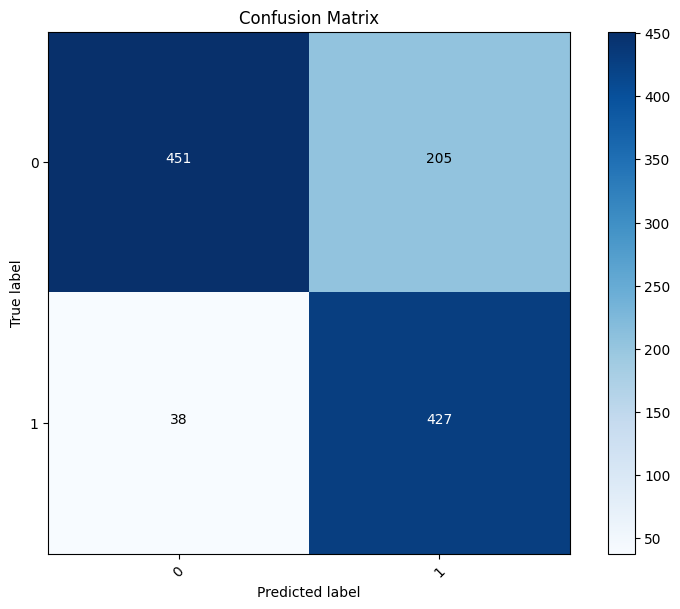

In [234]:
data_set = data_set.dropna()
data_set = data_set.sort_index()
data_set = data_set[np.all(data_set != np.inf, axis=1)]
feature_names = data_set.drop(["Symbol", "class", "data_type"], axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(data_set.loc[:, feature_names].astype('float'),
                                                    data_set.loc[:, 'class'].astype('int'), 
                                                    test_size = 0.2,
                                                    shuffle=False)


xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42) # squarederror

params = {
    # "colsample_bytree": [0.7, 0.3],
    # "gamma": [0, 0.5],
    "learning_rate": [0.1, 0.03, 0.003], # default 0.1 
    "max_depth": [2, 6], # default 3
    "n_estimators": [100, 300, 600], # default 100
    # "subsample": [0.6, 0.4]
}

kfold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

model = GridSearchCV(xgb_model, 
                     param_grid=params,
                     cv=kfold,
                     verbose=1,
                     n_jobs=6)


model.fit(X_train, y_train)


predict = model.best_estimator_.predict(X_test)
# predict_proba = random_forest_model.best_estimator_.predict_proba(X_test)

# rate, _ = optimal_threshold(predict_proba[:, 1])

# print(rate)
print(classification_report(y_test, predict))
print("accuracy: ", accuracy_score(y_test, predict))
# print(confusion_matrix(y_test, predict))
plot_confusion_matrix(y_test, predict, classes=[0, 1])


In [235]:
from joblib import dump, load
dump(model, os.path.join(config.MODELS_PATH, "xgb_model_new__.joblib"))

['/Users/levperla/PycharmProjects/ploutos/data/models/xgb_model_new.joblib']

In [184]:
model.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.003,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 600,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/levperla/PycharmProjects/ploutos/plutos.conda/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

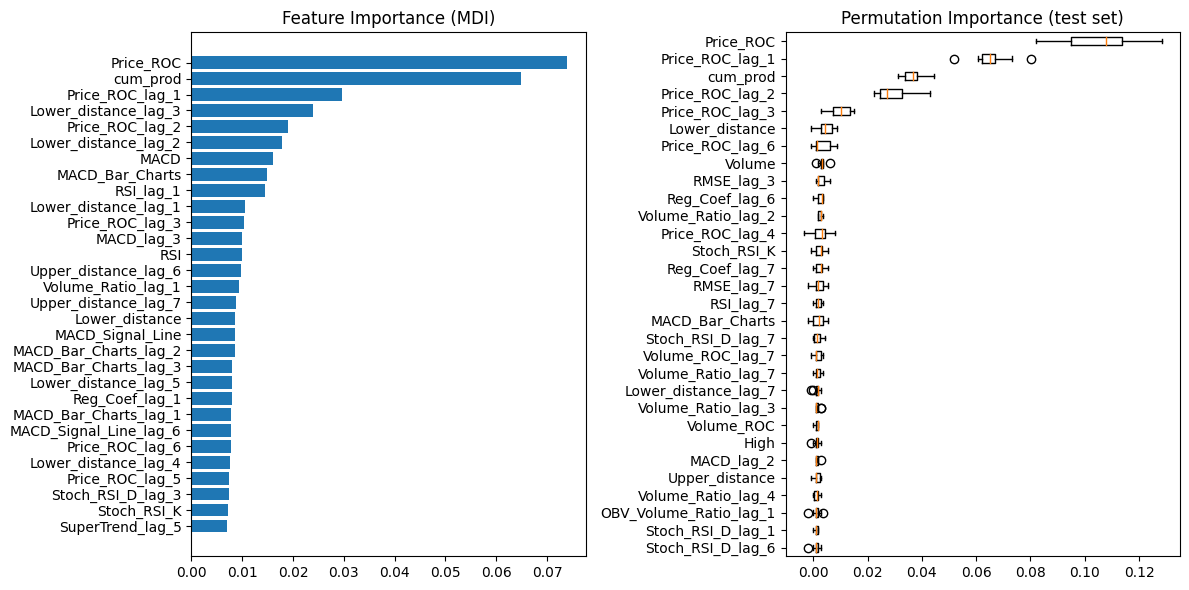

In [203]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


feature_importance = model.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, feature_names[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()[-30:]
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Eval

In [63]:
from datetime import date, timedelta

'2023-12-05'

In [374]:
BINANCE_SYMBOLS = get_binance_symbols(only_usdt=True)
DAYS_BEFORE = 30

DATE_BEFORE_TODAY = (date.today() - timedelta(days=DAYS_BEFORE)).strftime("%Y-%m-%d")
eval_candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time=DATE_BEFORE_TODAY)
eval_candels_df.head()

  0%|          | 0/494 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,Symbol
Time,,,,,,
2023-12-06 03:00:00+03:00,44073.82,44297.21,43335.28,43762.69,51431.10492,BTCUSDT
2023-12-07 03:00:00+03:00,43762.69,44047.33,42821.10,43273.14,47103.26845,BTCUSDT
2023-12-08 03:00:00+03:00,43273.15,44700.00,43081.10,44170.99,42900.37556,BTCUSDT
2023-12-09 03:00:00+03:00,44171.00,44358.02,43584.51,43713.60,24925.97008,BTCUSDT
2023-12-10 03:00:00+03:00,43713.59,44049.00,43563.00,43789.51,18956.61758,BTCUSDT


In [378]:
eval_features_df = add_features(eval_candels_df, EXPERIMENT_CONFIG)
eval_features_df.head()

  0%|          | 0/392 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_before_pump,Trailing_ATR,SuperTrend,MACD,MACD_Signal_Line,MACD_Bar_Charts,RSI,OBV_Volume_Ratio,Upper_distance,Lower_distance,CMF,Price_ROC,Volume_ROC,Volume_Ratio,Stoch_RSI_K,Stoch_RSI_D,Reg_Coef,RMSE,SuperTrend_lag_1,SuperTrend_lag_2,SuperTrend_lag_3,SuperTrend_lag_4,SuperTrend_lag_5,SuperTrend_lag_6,SuperTrend_lag_7,MACD_Signal_Line_lag_1,MACD_Signal_Line_lag_2,MACD_Signal_Line_lag_3,MACD_Signal_Line_lag_4,MACD_Signal_Line_lag_5,MACD_Signal_Line_lag_6,MACD_Signal_Line_lag_7,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_lag_4,MACD_lag_5,MACD_lag_6,MACD_lag_7,MACD_Bar_Charts_lag_1,MACD_Bar_Charts_lag_2,MACD_Bar_Charts_lag_3,MACD_Bar_Charts_lag_4,MACD_Bar_Charts_lag_5,MACD_Bar_Charts_lag_6,MACD_Bar_Charts_lag_7,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,RSI_lag_7,OBV_Volume_Ratio_lag_1,OBV_Volume_Ratio_lag_2,OBV_Volume_Ratio_lag_3,OBV_Volume_Ratio_lag_4,OBV_Volume_Ratio_lag_5,OBV_Volume_Ratio_lag_6,OBV_Volume_Ratio_lag_7,Upper_distance_lag_1,Upper_distance_lag_2,Upper_distance_lag_3,Upper_distance_lag_4,Upper_distance_lag_5,Upper_distance_lag_6,Upper_distance_lag_7,Lower_distance_lag_1,Lower_distance_lag_2,Lower_distance_lag_3,Lower_distance_lag_4,Lower_distance_lag_5,Lower_distance_lag_6,Lower_distance_lag_7,CMF_lag_1,CMF_lag_2,CMF_lag_3,CMF_lag_4,CMF_lag_5,CMF_lag_6,CMF_lag_7,Price_ROC_lag_1,Price_ROC_lag_2,Price_ROC_lag_3,Price_ROC_lag_4,Price_ROC_lag_5,Price_ROC_lag_6,Price_ROC_lag_7,Volume_ROC_lag_1,Volume_ROC_lag_2,Volume_ROC_lag_3,Volume_ROC_lag_4,Volume_ROC_lag_5,Volume_ROC_lag_6,Volume_ROC_lag_7,Volume_Ratio_lag_1,Volume_Ratio_lag_2,Volume_Ratio_lag_3,Volume_Ratio_lag_4,Volume_Ratio_lag_5,Volume_Ratio_lag_6,Volume_Ratio_lag_7,Stoch_RSI_K_lag_1,Stoch_RSI_K_lag_2,Stoch_RSI_K_lag_3,Stoch_RSI_K_lag_4,Stoch_RSI_K_lag_5,Stoch_RSI_K_lag_6,Stoch_RSI_K_lag_7,Stoch_RSI_D_lag_1,Stoch_RSI_D_lag_2,Stoch_RSI_D_lag_3,Stoch_RSI_D_lag_4,Stoch_RSI_D_lag_5,Stoch_RSI_D_lag_6,Stoch_RSI_D_lag_7,Reg_Coef_lag_1,Reg_Coef_lag_2,Reg_Coef_lag_3,Reg_Coef_lag_4,Reg_Coef_lag_5,Reg_Coef_lag_6,Reg_Coef_lag_7,RMSE_lag_1,RMSE_lag_2,RMSE_lag_3,RMSE_lag_4,RMSE_lag_5,RMSE_lag_6,RMSE_lag_7
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-07 03:00:00+03:00,99.294071,99.435901,98.813484,98.881353,47103.26845,BTCUSDT,0.0,2.074844,0.622417,102.052064,0.000000,0.000000,0.000000,71.467109,0.000000,0.916837,0.165337,-1.940342,2.074844,-8.922720,1.000000,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-08 03:00:00+03:00,98.183343,100.909290,99.413457,100.932987,42900.37556,BTCUSDT,0.0,2.074844,0.756276,102.052064,0.163663,0.032733,0.130930,71.467109,1.000000,0.916837,0.165337,-1.940342,2.074844,-8.922720,0.918579,NaN,NaN,0.0,0.0,102.052064,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,71.467109,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.916837,NaN,NaN,NaN,NaN,NaN,NaN,0.165337,NaN,NaN,NaN,NaN,NaN,NaN,-1.940342,NaN,NaN,NaN,NaN,NaN,NaN,2.074844,NaN,NaN,NaN,NaN,NaN,NaN,-8.922720,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-09 03:00:00+03:00,100.220494,100.137277,100.575120,99.887827,24925.97008,BTCUSDT,0.0,2.074844,0.760032,102.052064,0.206649,0.067516,0.139133,71.467109,0.721112,0.916837,0.165337,-1.940342,-1.035499,-41.898014,0.558515,NaN,NaN,0.0,0.0,102.052064,102.052064,Na

In [379]:
eval_features_df_today = eval_features_df.loc[eval_features_df.index.max()].copy()
eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.feature_names_in_])

In [380]:
best_symbols = eval_features_df_today.loc[eval_features_df_today.predict ==1 ,['Symbol', 'predict', 'proba']].sort_values('proba', ascending=False).head(50)
best_symbols

,Symbol,predict,proba
Time,,,
2024-01-05 03:00:00+03:00,LOOMUSDT,1,0.702757
2024-01-05 03:00:00+03:00,HIFIUSDT,1,0.679492
2024-01-05 03:00:00+03:00,VICUSDT,1,0.648866
2024-01-05 03:00:00+03:00,RPLUSDT,1,0.639488
2024-01-05 03:00:00+03:00,ATAUSDT,1,0.508893


In [ ]:
# # Plot one
# for symb in best_symbols.Symbol.values:
#     symb_candels = eval_candels_df[eval_candels_df.Symbol == symb]
#     symb_proba = int(best_symbols[best_symbols.Symbol == symb].proba.values[0] * 100) / 100
    
#     min_price = symb_candels.Close.min()
#     max_price = symb_candels.Close.max()
#     yield_before = int((max_price / min_price - 1) * 100)
    
#     symb_candels.Close.plot()
#     plt.title(f'{symb} Prices | proba {symb_proba} | yield before {yield_before}%')
#     plt.xlabel('Date')
#     plt.ylabel('Price (USD)')
#     plt.grid(True)
#     plt.axhline(y=(min_price), color='red')
#     plt.axhline(y=(max_price), color='red')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

In [424]:
from io import BytesIO

def create_plot_best_symbols(eval_candels_df, best_symbols, show=False):

    # Create a figure with 2 rows and 5 columns for subplots
    n_rows = np.ceil(best_symbols.shape[0] / 5).astype(int)
    fig, axes = plt.subplots(nrows=n_rows, ncols=5, figsize=(20, n_rows * 4))

    # Flatten the 2D array of axes to easily iterate through them
    axes = axes.flatten()

    for i, symb in enumerate(best_symbols.Symbol.values[:4]):
        symb_candels = eval_candels_df[eval_candels_df.Symbol == symb]
        symb_proba = int(best_symbols[best_symbols.Symbol == symb].proba.values[0] * 100) / 100
        
        min_price = symb_candels.loc[symb_candels.index.min(), 'Close']
        max_price = symb_candels.loc[symb_candels.index.max(), 'Close']
        yield_before = int((max_price / min_price - 1) * 100)
        
        # Get the respective axis for the current subplot
        ax = axes[i]
        
        symb_candels.Close.plot(ax=ax)
        ax.set_title(f'{symb} Prices | proba {symb_proba} | yield before {yield_before}%', size=10, color='black', fontweight="bold")
        ax.set_xlabel(None)
        ax.set_ylabel('Price (USD)')
        ax.grid(True)
        ax.axhline(y=min_price, color='red')
        ax.axhline(y=max_price, color='green')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()

    # Hide any empty subplots if there are fewer than 10 symbols
    for i in range(len(best_symbols.Symbol.values), n_rows * 5):
        axes[i].axis('off')

    # Display the entire figure containing all subplots
    if show:
        plt.show()
    else:
        # Save the plot as a PNG image
        img_buffer = BytesIO()
        plt.savefig(img_buffer, format='png')
        img_buffer.seek(0)
        plt.close()
        return img_buffer


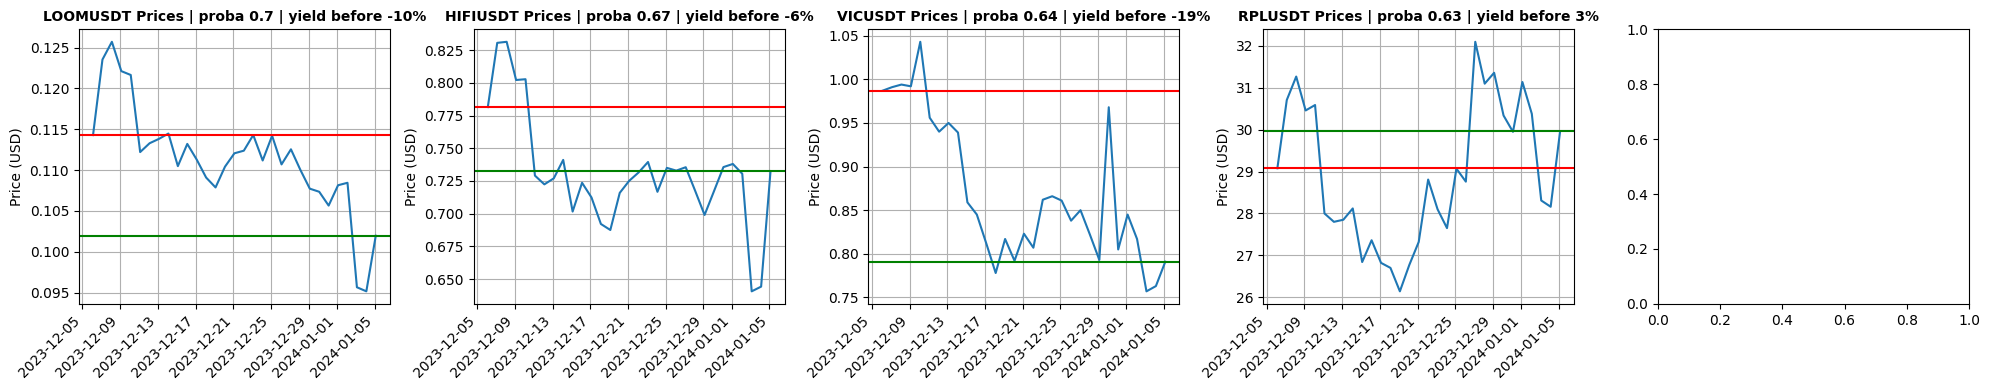

In [427]:
plots_buffer = create_plot_best_symbols(eval_candels_df, best_symbols, show=True)

In [428]:
def eval_model(exp_config=EXPERIMENT_CONFIG):

    # Get data
    print('Start to get candels')
    BINANCE_SYMBOLS = get_binance_symbols(only_usdt=True)
    DAYS_BEFORE = 30
    DATE_BEFORE_TODAY = (date.today() - timedelta(days=DAYS_BEFORE)).strftime("%Y-%m-%d")
    eval_candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time=DATE_BEFORE_TODAY)
    
    
    # Generate features
    print('Start to generate features')
    eval_features_df = add_features(eval_candels_df, exp_config)
    
    
    # Load model
    model = load(os.path.join(config.MODELS_PATH, "xgb_model_new.joblib"))
    
    # Predict for today
    print('Start to predict')
    eval_features_df_today = eval_features_df.loc[eval_features_df.index.max()].copy()
    eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
    eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.feature_names_in_])
    
    # Find best symbols
    N_BEST_SYMBOLS = 50
    best_symbols = (eval_features_df_today.loc[eval_features_df_today.predict ==1 ,['Symbol', 'predict', 'proba']]
                                         .sort_values('proba', ascending=False)
                                         .head(N_BEST_SYMBOLS)
                   )
    
    # Make plots
    plots_buffer = create_plot_best_symbols(eval_candels_df, best_symbols, show=True)
    
    return plots_buffer

Start to get candels


  0%|          | 0/494 [00:00<?, ?it/s]

Start to generate features


  0%|          | 0/392 [00:00<?, ?it/s]

Start to predict


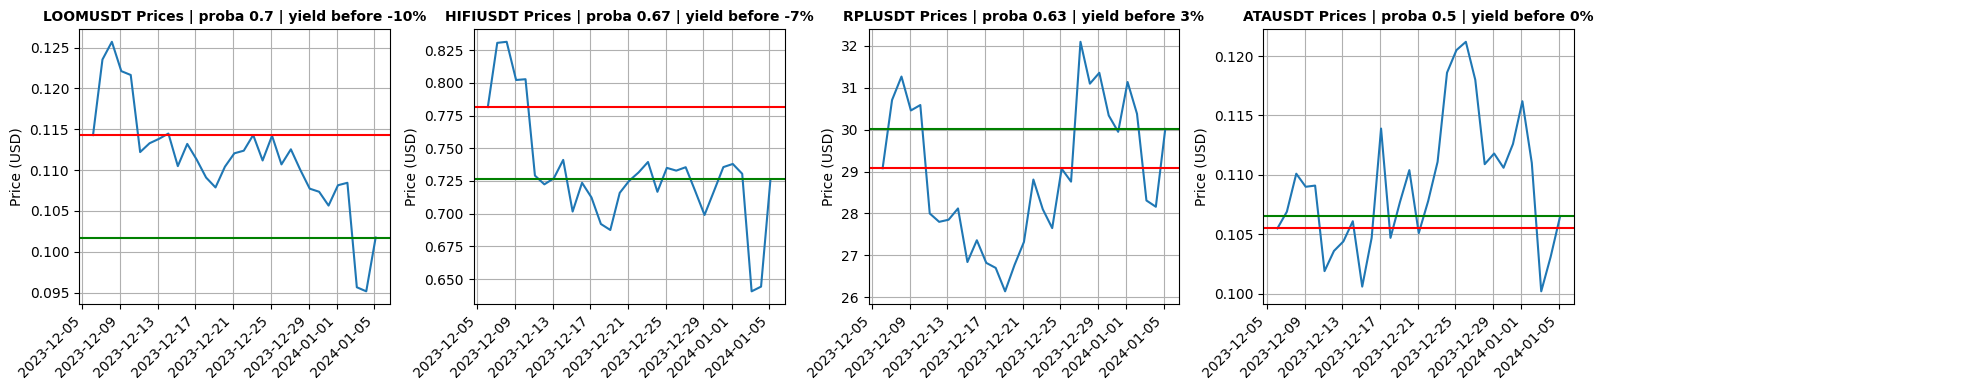

In [429]:
eval_model(exp_config=EXPERIMENT_CONFIG)

In [435]:
'\n'.join(best_symbols.Symbol.values.tolist())

'LOOMUSDT\nHIFIUSDT\nVICUSDT\nRPLUSDT\nATAUSDT'

In [281]:
BINANCE_SYMBOLS

array(['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'BCCUSDT', 'NEOUSDT', 'LTCUSDT',
       'QTUMUSDT', 'ADAUSDT', 'XRPUSDT', 'EOSUSDT', 'TUSDUSDT',
       'IOTAUSDT', 'XLMUSDT', 'ONTUSDT', 'TRXUSDT', 'ETCUSDT', 'ICXUSDT',
       'VENUSDT', 'NULSUSDT', 'VETUSDT', 'PAXUSDT', 'BCHABCUSDT',
       'BCHSVUSDT', 'USDCUSDT', 'LINKUSDT', 'WAVESUSDT', 'BTTUSDT',
       'USDSUSDT', 'ONGUSDT', 'HOTUSDT', 'ZILUSDT', 'ZRXUSDT', 'FETUSDT',
       'BATUSDT', 'XMRUSDT', 'ZECUSDT', 'IOSTUSDT', 'CELRUSDT',
       'DASHUSDT', 'NANOUSDT', 'OMGUSDT', 'THETAUSDT', 'ENJUSDT',
       'MITHUSDT', 'MATICUSDT', 'ATOMUSDT', 'TFUELUSDT', 'ONEUSDT',
       'FTMUSDT', 'ALGOUSDT', 'USDSBUSDT', 'GTOUSDT', 'ERDUSDT',
       'DOGEUSDT', 'DUSKUSDT', 'ANKRUSDT', 'WINUSDT', 'COSUSDT',
       'NPXSUSDT', 'COCOSUSDT', 'MTLUSDT', 'TOMOUSDT', 'PERLUSDT',
       'DENTUSDT', 'MFTUSDT', 'KEYUSDT', 'STORMUSDT', 'DOCKUSDT',
       'WANUSDT', 'FUNUSDT', 'CVCUSDT', 'CHZUSDT', 'BANDUSDT', 'BUSDUSDT',
       'BEAMUSDT', 'XTZUSDT', 'RENUSDT', 'RVN

In [285]:
eval_candels_df = compose_binance_candles_df(BINANCE_SYMBOLS, start_time='2023-10-10', end_time='2023-12-20')


# Generate features
print('Start to generate features')
eval_features_df = add_features(eval_candels_df, exp_config=EXPERIMENT_CONFIG)


# Load model
model = load(os.path.join(config.MODELS_PATH, "xgb_model_new.joblib"))

# Predict for today
print('Start to predict')
eval_features_df_today = eval_features_df.dropna()
eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.feature_names_in_])


  0%|          | 0/494 [00:00<?, ?it/s]

Start to generate features


  0%|          | 0/396 [00:00<?, ?it/s]

Start to predict


/var/folders/jw/6fn4wc097x782s0059kltcsh0000gn/T/ipykernel_74452/1731832329.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_features_df_today.loc[:, 'proba'] = model.best_estimator_.predict_proba(eval_features_df_today.loc[:, model.feature_names_in_])[:, 1]
/var/folders/jw/6fn4wc097x782s0059kltcsh0000gn/T/ipykernel_74452/1731832329.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_features_df_today.loc[:, 'predict'] = model.best_estimator_.predict(eval_features_df_today.loc[:, model.featur

In [296]:
symb_df.head()

,Open,High,Low,Close,Volume,Symbol,cum_prod,yield_before_pump,Trailing_ATR,SuperTrend,MACD,MACD_Signal_Line,MACD_Bar_Charts,RSI,OBV_Volume_Ratio,Upper_distance,Lower_distance,CMF,Price_ROC,Volume_ROC,Volume_Ratio,Stoch_RSI_K,Stoch_RSI_D,Reg_Coef,RMSE,SuperTrend_lag_1,SuperTrend_lag_2,SuperTrend_lag_3,SuperTrend_lag_4,SuperTrend_lag_5,SuperTrend_lag_6,SuperTrend_lag_7,MACD_Signal_Line_lag_1,MACD_Signal_Line_lag_2,MACD_Signal_Line_lag_3,MACD_Signal_Line_lag_4,MACD_Signal_Line_lag_5,MACD_Signal_Line_lag_6,MACD_Signal_Line_lag_7,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_lag_4,MACD_lag_5,MACD_lag_6,MACD_lag_7,MACD_Bar_Charts_lag_1,MACD_Bar_Charts_lag_2,MACD_Bar_Charts_lag_3,MACD_Bar_Charts_lag_4,MACD_Bar_Charts_lag_5,MACD_Bar_Charts_lag_6,MACD_Bar_Charts_lag_7,RSI_lag_1,RSI_lag_2,RSI_lag_3,RSI_lag_4,RSI_lag_5,RSI_lag_6,RSI_lag_7,OBV_Volume_Ratio_lag_1,OBV_Volume_Ratio_lag_2,OBV_Volume_Ratio_lag_3,OBV_Volume_Ratio_lag_4,OBV_Volume_Ratio_lag_5,OBV_Volume_Ratio_lag_6,OBV_Volume_Ratio_lag_7,Upper_distance_lag_1,Upper_distance_lag_2,Upper_distance_lag_3,Upper_distance_lag_4,Upper_distance_lag_5,Upper_distance_lag_6,Upper_distance_lag_7,Lower_distance_lag_1,Lower_distance_lag_2,Lower_distance_lag_3,Lower_distance_lag_4,Lower_distance_lag_5,Lower_distance_lag_6,Lower_distance_lag_7,CMF_lag_1,CMF_lag_2,CMF_lag_3,CMF_lag_4,CMF_lag_5,CMF_lag_6,CMF_lag_7,Price_ROC_lag_1,Price_ROC_lag_2,Price_ROC_lag_3,Price_ROC_lag_4,Price_ROC_lag_5,Price_ROC_lag_6,Price_ROC_lag_7,Volume_ROC_lag_1,Volume_ROC_lag_2,Volume_ROC_lag_3,Volume_ROC_lag_4,Volume_ROC_lag_5,Volume_ROC_lag_6,Volume_ROC_lag_7,Volume_Ratio_lag_1,Volume_Ratio_lag_2,Volume_Ratio_lag_3,Volume_Ratio_lag_4,Volume_Ratio_lag_5,Volume_Ratio_lag_6,Volume_Ratio_lag_7,Stoch_RSI_K_lag_1,Stoch_RSI_K_lag_2,Stoch_RSI_K_lag_3,Stoch_RSI_K_lag_4,Stoch_RSI_K_lag_5,Stoch_RSI_K_lag_6,Stoch_RSI_K_lag_7,Stoch_RSI_D_lag_1,Stoch_RSI_D_lag_2,Stoch_RSI_D_lag_3,Stoch_RSI_D_lag_4,Stoch_RSI_D_lag_5,Stoch_RSI_D_lag_6,Stoch_RSI_D_lag_7,Reg_Coef_lag_1,Reg_Coef_lag_2,Reg_Coef_lag_3,Reg_Coef_lag_4,Reg_Coef_lag_5,Reg_Coef_lag_6,Reg_Coef_lag_7,RMSE_lag_1,RMSE_lag_2,RMSE_lag_3,RMSE_lag_4,RMSE_lag_5,RMSE_lag_6,RMSE_lag_7,proba,predict
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-18 03:00:00+03:00,105.463183,102.534562,103.855422,101.173709,4169791.71,FLOWUSDT,0.0,-0.952381,0.492374,104.425926,1.174176,0.638179,0.535997,58.903532,2.937480,0.326555,0.398159,0.22187,-2.927928,2.402889,0.807328,51.571959,51.571959,0.0,0.0,105.503591,105.695913,103.032659,100.547435,97.464959,99.341244,99.341244,0.504179,0.310766,0.118246,-0.007811,-0.034786,-0.014981,0.000000,1.277835,1.080842,0.622478,0.100088,-0.114009,-0.074903,0.000000,0.773655,0.770076,0.504232,0.107899,-0.079223,-0.059923,0.000000,58.903532,58.903532,58.903532,58.903532,58.903532,58.903532,58.903532,4.032093,2.682906,2.297535,1.046070,0.084714,-1.000000,0.000000,0.326555,0.326555,0.326555,0.326555,0.326555,0.326555,0.326555,0.398159,0.398159,0.398159,0.398159,0.398159,0.398159,0.398159,0.22187,0.22187,0.22187,0.22187,0.22187,0.22187,0.22187,-1.769912,0.668151,4.418605,3.117506,0.240385,-0.952381,-0.952381,-46.684091,36.521847,-19.380188,83.880511,9.255467,-33.705243,-33.705243,0.772713,1.415445,1.084204,1.356862,0.766705,0.684934,1.000000,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,51.571959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009863,0
2023-10-19 03:00:00+03:00,102.612827,100.691244,99.518072,99.061033,5918526.24,FLOWUSDT,0.0,-0.952381,0.603161,101.612560,0.911048,0.692753,0.218295,58.903532,1.069549,0.326555,0.398159,0.22187,-2.088167,41.938175,1.130202,51.571959,51.571959,0.0,0.0,104.425926,105.503591,105.695913,103.032659,100.547435,97.464959,99.341244,0.638179,0.504179,0.310766,0.118246,-0.007811,-0.034786,-0.014981,1.174176,1.277835,1.080842,0.622478,0.100088,-0.

In [319]:
eval_features_df_today.sort_index().groupby('Symbol').Close.shift(-10)

Time
2023-10-18 03:00:00+03:00    124.428078
2023-10-18 03:00:00+03:00    112.861379
2023-10-18 03:00:00+03:00    125.224455
2023-10-18 03:00:00+03:00    113.321570
2023-10-18 03:00:00+03:00    105.534496
                                ...    
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
2024-01-05 03:00:00+03:00           NaN
Name: Close, Length: 30420, dtype: float64

In [320]:
eval_features_df_today = eval_features_df_today.sort_values('Symbol')
eval_features_df_today['lead_10_price'] = eval_features_df_today.groupby('Symbol').Close.shift(-10)
eval_features_df_today['yield'] = (eval_features_df_today['lead_10_price'] / eval_features_df_today['Close'] - 1) * 100

In [326]:
eval_features_df_today.loc[eval_features_df_today['predict'] == 1,['Close', 'Symbol', 'predict', 'yield']]['yield']

count    986.000000
mean      13.450075
std       44.323278
min      -65.320122
25%       -5.599027
50%        3.718325
75%       16.615199
max      559.749145
Name: yield, dtype: float64

count    400.000000
mean      13.383082
std       46.523928
min      -65.320122
25%       -6.741686
50%        1.814674
75%       17.587111
max      436.284722
Name: yield, dtype: float64

depo 92
profit 107.06465413215423
profit 116.37462405668938%


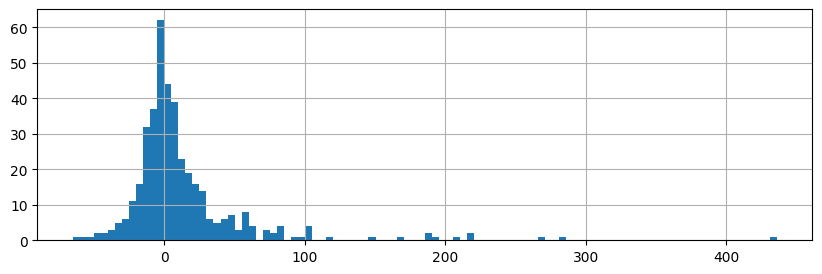

In [371]:
yield_lists = eval_features_df_today.loc[(eval_features_df_today['predict'] == 1) & (eval_features_df_today['proba'] < 0.60),['Close', 'Symbol', 'predict', 'yield']]['yield']

print(yield_lists.describe())
fig = plt.figure(figsize=(10, 3))
yield_lists.hist(bins=100)

cost_per_tr = 2
max_tr_per_day = yield_lists.groupby(yield_lists.index).count().max()
depo = max_tr_per_day * cost_per_tr
profit = (cost_per_tr * yield_lists / 100).sum()
print(f"\ndepo {depo}")
print(f'profit {profit}')
print(f'profit {profit/depo * 100}%')

depo 376
profit 265.2354727511573
profit 70.54134913594609%


In [350]:
yield_lists.groupby(yield_lists.index).count().max()

188

In [ ]:
for i, symb in enumerate(eval_features_df_today.Symbol.unique()):
    symb_df = eval_features_df_today[eval_features_df_today.Symbol == symb].copy()
    symb_df['lead_10_price'] = symb_df.sort_index().groupby('Symbol').Close.shift(-10)
    symb_df['yield'] = (symb_df['lead_10_price'] / symb_df['Close'] - 1) * 100
    
    fig = plt.figure(figsize=(15, 3))
    symb_df = symb_df.dropna()
    symb_df.Close.plot()
    for pump_index in symb_df[symb_df.predict == 1].index:
        plt.axvline(x=pump_index)
        proba = int(symb_df.loc[pump_index,'proba'] * 100) / 100
        yield_ = int(symb_df.loc[pump_index,'yield'] * 100) / 100
        plt.text(pump_index, symb_df.Close.max() * 0.9,  f'{proba}', color='red', fontsize=10)
        plt.text(pump_index, symb_df.Close.max() * 0.8,  f'{yield_}%', color='red', fontsize=10)
    plt.title(symb)
    plt.show()
    if i >= 20:
        break